## MERFISH mouse liver: Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

This notebook contains a prototype implementation of an ovrl.py analysis script for vizgen's MERFISH liver showcase data set. It runs tha basic ovrlpy analysis pipeline and stores the result;

#### Imports:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)

7.059797644615173e-05


#### Parameter definition:

In [3]:
n_sample = 1
n_slice = 1

img_path_wall = f'../../vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/images/mosaic_Cellbound3_z4.tif'
img_path_dapi = f'../../vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/images/mosaic_DAPI_z4.tif'
coordinate_path = f'../../../../raw_data/vizgen-merfish/vz-liver-showcase/Liver{n_sample}Slice{n_slice}/detected_transcripts.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [4]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

perf_=time.perf_counter()

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(f'Loading time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()


Loading time: 263.4520389549434


                  x             y             z
count  2.761887e+08  2.761887e+08  2.761887e+08
mean   3.551086e+03  3.354382e+03  2.686848e+00
std    1.993278e+03  1.977380e+03  1.882738e+00
min    1.000000e-04  6.000000e-05  0.000000e+00
25%    1.793756e+03  1.637970e+03  1.000000e+00
50%    3.618509e+03  3.353441e+03  3.000000e+00
75%    5.278261e+03  5.026416e+03  4.000000e+00
max    6.999999e+03  6.999999e+03  6.000000e+00


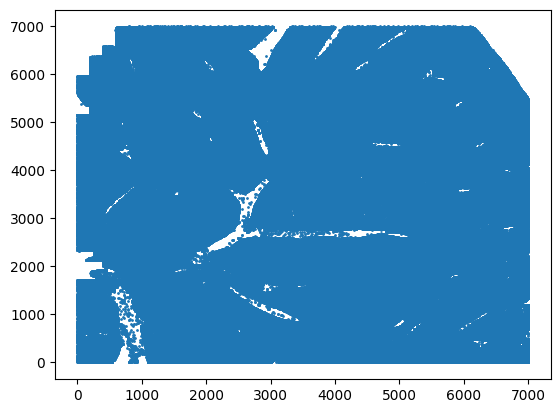

In [5]:
df.columns = ["x", "y", "z", "gene"]

df = df[~df.gene.str.contains("Blank")]
df.gene = df.gene.astype("category")

raw_df = df.copy()

gene_counts = df.gene.value_counts()
genes = gene_counts.index

x_lims = [2000, 9000]
y_lims = [1000, 8000]


mins = pd.DataFrame(
    [(0, 0)],
    columns=("x", "y"),
)

df_mask = (
    (df.x > x_lims[0]) & (df.x < x_lims[1]) & (df.y > y_lims[0]) & (df.y < y_lims[1])
)
df = df[df_mask]
df.x -= x_lims[0]
df.y -= y_lims[0]

plt.scatter(df.x[::100], df.y[::100], s=1)

coordinate_df = df.copy()
del df

coordinate_df.head()

print(coordinate_df.describe())

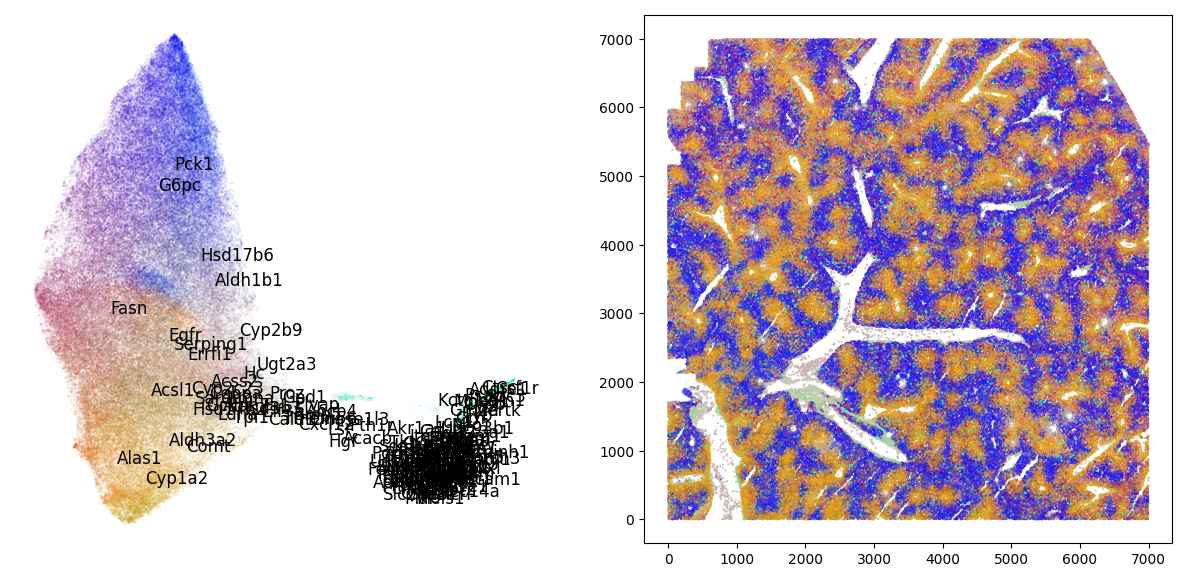

In [9]:
import ovrlpy

visualizer = ovrlpy.load_visualizer("./publication/vizgen-liver/vizgen-liver.vis")

signal_integrity,signal_strength = visualizer.integrity_map, visualizer.signal_map

visualizer.plot_fit()

In [11]:
np.array([1100,1600,1100,1600])*2

array([2200, 3200, 2200, 3200])

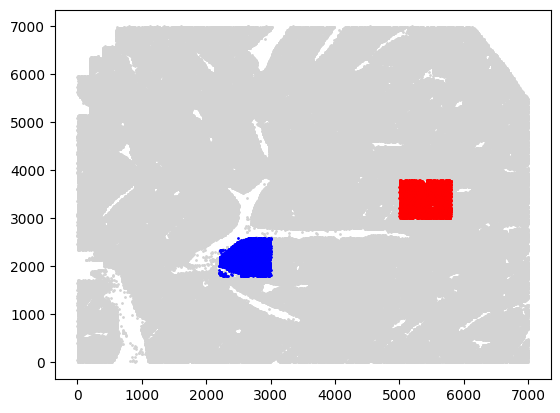

In [32]:

# crop out a central part of the tissue to create artificial overlaps:
xb_,_xb,yb_,_yb = 5000, 5800, 3000, 3800
xt_,_xt,yt_,_yt = 2200, 3000, 1800, 2600
fold_bottom_mask = coordinate_df.x.between(xb_,_xb)&coordinate_df.y.between(yb_,_yb)
fold_top_mask = coordinate_df.x.between(xt_,_xt)&coordinate_df.y.between(yt_,_yt)

fold_df_bottom = coordinate_df[fold_bottom_mask].copy()
fold_df_bottom['fold'] = 'bottom'
fold_df_top = coordinate_df[fold_top_mask].copy()
fold_df_top['fold'] = 'top'

plt.scatter(coordinate_df.x[::1000],coordinate_df.y[::1000],c='lightgrey',s=1)
plt.scatter(fold_df_bottom.x[::1000],fold_df_bottom.y[::1000],c='r',s=1)
plt.scatter(fold_df_top.x[::1000],fold_df_top.y[::1000],c='b',s=1)

# move the signal to origin
fold_df_bottom.x-=xb_
fold_df_top.x-=xt_

fold_df_bottom.y-=yb_
fold_df_top.y-=yt_

ovrlpy.pre_process_coordinates(fold_df_bottom)
ovrlpy.pre_process_coordinates(fold_df_top)

fold_df_folded = fold_df_bottom.copy()
fold_df_folded.z-=fold_df_bottom.z.max()-fold_df_top.z.min()
fold_df_folded = pd.concat([fold_df_folded,fold_df_top])

ovrlpy.pre_process_coordinates(fold_df_folded)

fold_bottom_centroids = pd.DataFrame.from_dict({'x':visualizer.pseudocell_locations_x ,'y':visualizer.pseudocell_locations_y})
fold_top_centroids = pd.DataFrame.from_dict({'x':visualizer.pseudocell_locations_x,'y':visualizer.pseudocell_locations_y})

fold_bottom_centroids = fold_bottom_centroids[fold_bottom_centroids.x.between(xb_,_xb-1)&fold_bottom_centroids.y.between(yb_,_yb-1)]
fold_bottom_centroids.x-=xb_
fold_bottom_centroids.y-=yb_

fold_top_centroids = fold_top_centroids[fold_top_centroids.x.between(xt_,_xt-1)&fold_top_centroids.y.between(yt_,_yt-1)]
fold_top_centroids.x-=xt_
fold_top_centroids.y-=yt_


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.49s/it]


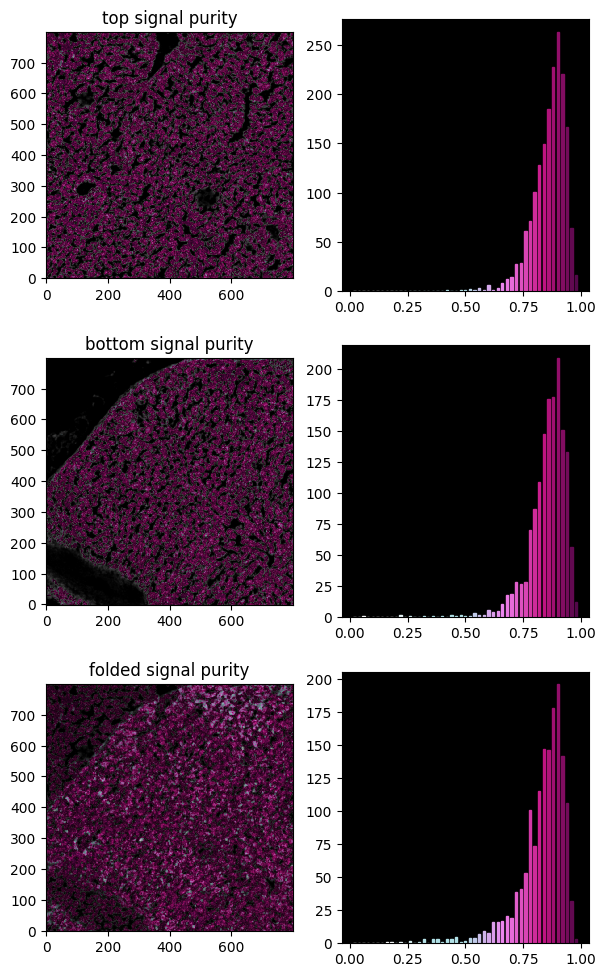

In [35]:
from matplotlib.colors import LinearSegmentedColormap
from ovrlpy._ovrlp import _BIH_CMAP as cmap
from ovrlpy._utils import _compute_divergence_patched  

min_expression=5

coherence_bottom, signal_bottom = _compute_divergence_patched(fold_df_bottom, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_top, signal_top = _compute_divergence_patched(fold_df_top, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_folded, signal_folded = _compute_divergence_patched(fold_df_folded, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

def plot_purity_distribution(coherence,ax=None):
    if ax is None:
        ax = plt.gca()
    vals,bins = np.histogram(coherence, bins=50, range=(0,1))
    colors = cmap(bins[1:-1])
    bars = ax.bar(bins[1:-1],vals[1:],width=0.01)
    for i,bar in enumerate(bars):
        bar.set_color(colors[i])

fig = plt.figure(figsize=(7,12))

ax = plt.subplot(321,facecolor='k')
plt.title('top signal purity')
plt.imshow(coherence_bottom.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_bottom.T/signal_bottom.max(), interpolation='nearest')
ax.invert_yaxis()
ax = plt.subplot(322,facecolor='k')
plot_purity_distribution(coherence_bottom[fold_bottom_centroids.x.astype(int),fold_bottom_centroids.y.astype(int)],ax=ax)

ax = plt.subplot(323,facecolor='k')
plt.title('bottom signal purity')
plt.imshow(coherence_top.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_top.T/signal_top.max(), interpolation='nearest')
ax.invert_yaxis()
ax = plt.subplot(324,facecolor='k')
plot_purity_distribution(coherence_top[fold_top_centroids.x.astype(int),fold_top_centroids.y.astype(int)],ax=ax)

ax = plt.subplot(325,facecolor='k')
plt.title('folded signal purity')
plt.imshow(coherence_folded.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_folded.T/signal_folded.max(), interpolation='nearest')
ax.invert_yaxis()
ax = plt.subplot(326,facecolor='k')
plot_purity_distribution(coherence_folded[fold_top_centroids.x.astype(int),fold_top_centroids.y.astype(int)],ax=ax)


/tmp/ipykernel_452372/3919369884.py:4: RuntimeWarning: divide by zero encountered in divide
  hist_quotient = hist_folded/hist_bottom
/tmp/ipykernel_452372/3919369884.py:4: RuntimeWarning: invalid value encountered in divide
  hist_quotient = hist_folded/hist_bottom


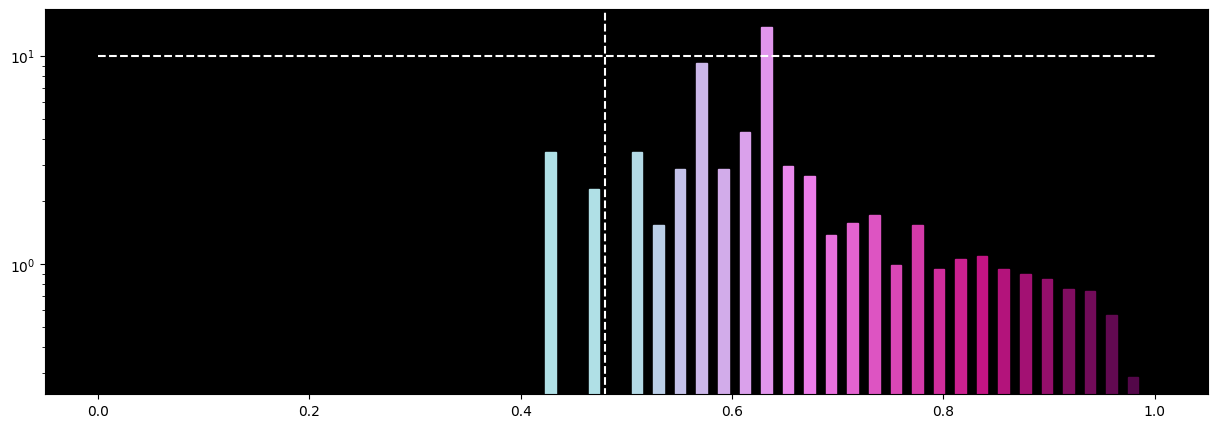

In [36]:
hist_top, bins,  = np.histogram(coherence_top[fold_top_centroids.x.astype(int),fold_top_centroids.y.astype(int)],bins=np.linspace(0,1,50),density=True)
hist_bottom, bins,  = np.histogram(coherence_bottom[fold_bottom_centroids.x.astype(int),fold_bottom_centroids.y.astype(int)],bins=np.linspace(0,1,50),density=True)
hist_folded, bins,  = np.histogram(coherence_folded[fold_top_centroids.x.astype(int),fold_top_centroids.y.astype(int)],bins=np.linspace(0,1,50),density=True)
hist_quotient = hist_folded/hist_bottom

plt.figure(figsize=(15,5))

ax = plt.subplot(111,facecolor='k')
colors = cmap(bins[1:-1])
bars = ax.bar(bins[1:-1],hist_quotient[1:],width=0.01)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    
ax.set_yscale('log')
plt.hlines(10,0,1,linestyles='dashed',color='w')
plt.vlines(0.48,0,500,linestyles='dashed',color='w')